<center><h1 style="font-size: 28px;"><b>Bloc 3 : Analyse prédictive de données structurées par l'intelligence artificielle</b></h1></center>


<h2 style="font-size: 20px;">Utilisation d'un algorithme d'apprentissage automatique supervisé (LSTM) pour effectuer des prévisions.</h2>

***Objectifs de l'algorithme :***

L’objectif de ce modèle est de prédire le nombre des observations françaises pour les 24 prochains mois ce qui permettrait notamment de structurer la partie hardware du site et de prévoir les ressources nécessaires à ces futures observations

Le choix du modèle LSTM, ou Long Short-Term Memory, revêt une importance particulière dans le cadre de notre analyse prédictive des observations sur iNaturalist en France. Les LSTM appartiennent à la famille des réseaux de neurones récurrents (RNN) ils se démarquent par leur capacité à gérer efficacement les séquences temporelles en capturant les dépendances complexes à long terme. Dans notre contexte, cette caractéristique est essentielle dans notre contexte, où les schémas de biodiversité peuvent être soumis à des variations saisonnières, à des tendances à long terme, et à des influences mutuelles entre les différentes périodes d'observation.
Cette architecture intègre des cellules mémoires qui permettent au réseau de conserver et d'oublier des informations au fil du temps, facilitant ainsi la capture d'informations pertinentes sur des périodes étendues. Ces caractéristiques font du LSTM un choix idéal pour notre tâche de prédiction à long terme, où la mémoire des tendances antérieures est cruciale pour une prédiction précise.
Voici son fonctionnement :

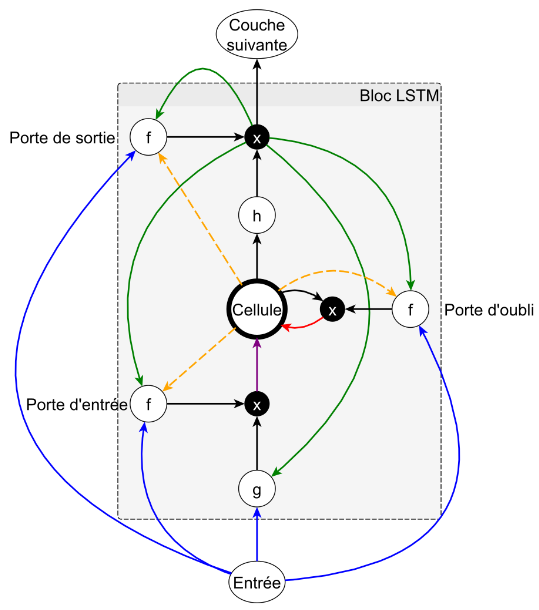

## 1. Imports des bibliothèques python

In [ ]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

import matplotlib.pyplot as plt


## 2. Prétraitement, transformation et visualisation des données


Données extaites du site iNaturalist.org : https://www.inaturalist.org/pages/developers - http://www.inaturalist.org/observations/gbif-observations-dwca.zip

Les données subissent un 1er traitement dans KNIME (data preparation) :
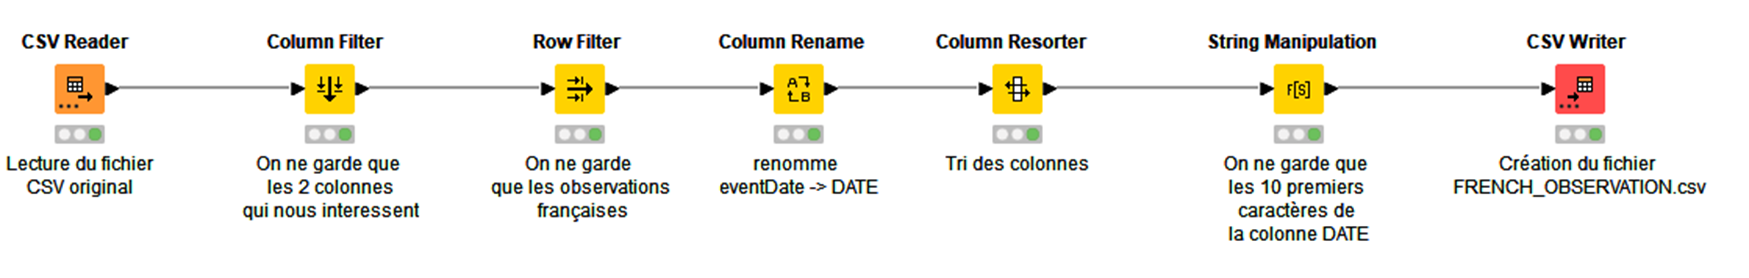

In [ ]:
#Import du fichier généré via KNIME
df = pd.read_csv('FRENCH_OBSERVATIONS_LSTM.csv')

In [ ]:
# Visualisation du dataset :
print(df)

              DATE         id countryCode     stateProvince
0       2019-01-31   20101692          FR          Lorraine
1       2019-01-31   20101910          FR          Lorraine
2       2021-05-23  140712376          FR             Corse
3       2021-05-23  140712379          FR             Corse
4       2021-05-28  140712381          FR             Corse
...            ...        ...         ...               ...
989588  2019-01-24   20086396          FR          Bretagne
989589  2019-01-24   20086405          FR          Bretagne
989590  2019-02-03   20088985          FR     Île-de-France
989591  2019-02-03   20088992          FR     Île-de-France
989592  2018-07-15   20096638          FR  Pays de la Loire

[989593 rows x 4 columns]


In [ ]:
# Vérification que les ID soient unique pour éviter les doublons
df['id'].nunique()


989593

In [ ]:
# Affichage des informations sur notre dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 989593 entries, 0 to 989592
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   DATE           989593 non-null  object
 1   id             989593 non-null  int64 
 2   countryCode    989593 non-null  object
 3   stateProvince  989592 non-null  object
dtypes: int64(1), object(3)
memory usage: 30.2+ MB


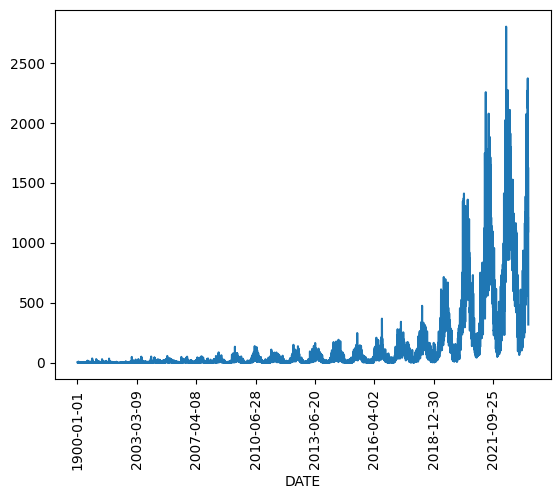

In [ ]:
# Représentation graphique des données

df_graph = df.groupby(['DATE'])['id'].count()
fig, ax = plt.subplots()

# Tracez le graphe en utilisant la série df
df_graph.plot(ax=ax)

# Faites pivoter les étiquettes des années sur l'axe des abscisses à 90 degrés
plt.xticks(rotation=90)

# Affichez le graphe
plt.show()

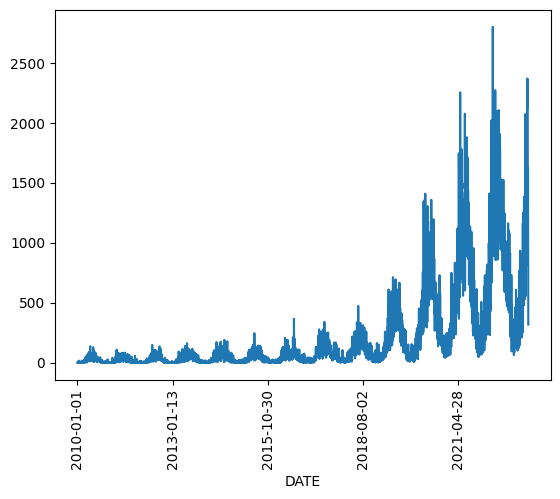

In [ ]:
#Traitement des valeurs abhérentes ou très peu significatives avant les années 2010 et réaffichage des valeurs

df_recherches_dates = df.loc[df['DATE'] >= '2010-01-01']
df_recherches_dates_graph = df_recherches_dates.groupby(['DATE'])['id'].count()
fig, ax = plt.subplots()

# Tracez le graphe en utilisant la série df
df_recherches_dates_graph.plot(ax=ax)

# Faites pivoter les étiquettes des années sur l'axe des abscisses à 90 degrés
plt.xticks(rotation=90)

# Affichez le graphe
plt.show()



In [ ]:
# On affine les valeur  : Restriction des données en ne selectionnant que celles qui sont aprés 2017
df = df.loc[df['DATE'] >= '2017-01-01']

#Pour meilleure analyse et visibilité, nous regroupons les valeur par mois, les données s'arretent au 30.04.2023
df = df.loc[df['DATE'] <= '2023-04-30']

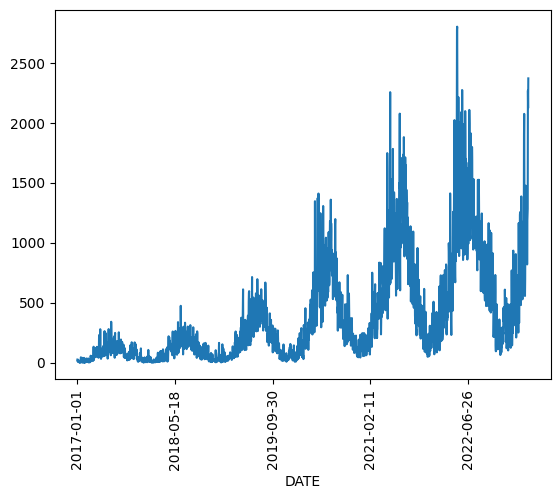

In [ ]:
# Affichage du graphique actualisé

df_graph = df.groupby(['DATE'])['id'].count()
fig, ax = plt.subplots()

# Tracez le graphe en utilisant la série df
df_graph.plot(ax=ax)

# Faites pivoter les étiquettes des années sur l'axe des abscisses à 90 degrés
plt.xticks(rotation=90)

# Affichez le graphe
plt.show()

In [ ]:
# Trie les données du dataset
df.sort_values("DATE",inplace=True)

In [ ]:
# Pour pouvoir exploiter les données par mois et prédire le nombre d'observations sur les mois suivants,
# on ne garde qu'une date, le 1er du mois, pour toutes les données du mois en cours
# Par ex, une observation faite le 06/05/2023 aura après le traitement une date de 01/05/2023
df['DATE'] = pd.to_datetime(df['DATE'])
df['DATE'] = df['DATE'].dt.to_period('M').dt.to_timestamp()



In [ ]:
# Maintenant que toutes les dates du mois sont regroupées sous une date unique, nous pouvons compter le nombre d'occurence d'obsservations par mois
df = df.groupby(['DATE'])['id'].count()

In [ ]:
print(df)

DATE
2017-01-01      409
2017-02-01      446
2017-03-01     1070
2017-04-01     2766
2017-05-01     3203
              ...  
2022-12-01     7711
2023-01-01     8098
2023-02-01    12419
2023-03-01    21548
2023-04-01    37293
Name: id, Length: 76, dtype: int64


In [ ]:
# Transformation du DF et changement de nom de la colonne pour améliorer la compréhension des données

print("Avant transformation en DataFrame : ", type(df))
df = pd.DataFrame(df)

print("Après transformation en DataFrame : ", type(df))
df.rename(columns={'id':'nb'}, inplace=True)


Avant transformation en DataFrame :  <class 'pandas.core.series.Series'>
Après transformation en DataFrame :  <class 'pandas.core.frame.DataFrame'>


In [ ]:
# Visualisation du Dataframe df
df

,nb
DATE,
2017-01-01,409
2017-02-01,446
2017-03-01,1070
2017-04-01,2766
2017-05-01,3203
...,...
2022-12-01,7711
2023-01-01,8098
2023-02-01,12419


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 76 entries, 2017-01-01 to 2023-04-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   nb      76 non-null     int64
dtypes: int64(1)
memory usage: 1.2 KB


<Axes: xlabel='DATE'>

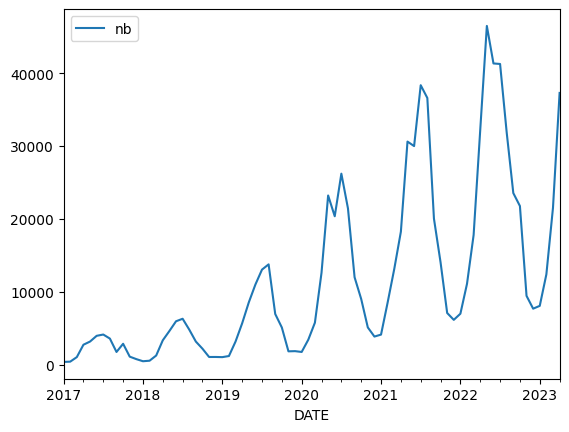

In [ ]:
df.plot()

## 3. Préparation des données pour le modèle

<u>a) Split des données en données d'entraînement et données de test</u>

In [ ]:
test_len = 13 # On considère que les 12 derniers mois constitueront nos données de test et les reste avant seront nos données d'entraînement

ind = len(df) - test_len
train = df[:ind] #train : toutes les données sauf les 12 derniers mois
test = df[ind:] #test : les 12 derniers mois

print(f'Longueur du dataset train : {len(train)}')
print(f'Longueur du dataset test : {len(test)}')


Longueur du dataset train : 63
Longueur du dataset test : 13


In [ ]:
#Visualisation de l'ensemble test
test

,nb
DATE,
2022-04-01,32227
2022-05-01,46482
2022-06-01,41336
2022-07-01,41265
2022-08-01,31873
2022-09-01,23562
2022-10-01,21787
2022-11-01,9469
2022-12-01,7711


  <u>b) Mise à l'échelle des données</u>

In [ ]:
# Mise à l'échelle des données test et train avec MinMaxScaler()
sc = MinMaxScaler()
train_sc = sc.fit_transform(train)
test_sc = sc.transform(test)

In [ ]:
# La mise à l'échelle des données transforme les données en nombre décimaux entre 0 et 1 pour une facilité de traitement
#Il faudra donc bien évidemment faire l'opération inverse après traitement

#La mise à l'échelle s'est faite avec les données train_sc, puis appliquée également sur les données test_sc.
# C'est pour cela qu'on peut trouver des données supérieures à 1 dans test_sc (pour les données plus grandes que la max des données présente dans train)
test_sc

array([[0.83855155],
       [1.21423677],
       [1.07861585],
       [1.07674468],
       [0.82922201],
       [0.6101887 ],
       [0.56340923],
       [0.23877293],
       [0.19244149],
       [0.20264073],
       [0.31651908],
       [0.55711048],
       [0.97206409]])

<u>c) Construction du train et test generators</u>

Comme on a ici une seule série, qui sera à la fois les données de départ (sur 12 mois, X) et la résultante (le mois suivant, y), il faut construire pour les 2 datasets de données,

In [ ]:
#on prend 12 données (sequence_length) pour prédire la prochaine donnée (out_len))
sequence_length = 12
out_len = 1

# Train Generator
train_gen = TimeseriesGenerator(data = train_sc,
                                targets = train_sc,
                                length = sequence_length,
                                batch_size = out_len)

# Test Generator
test_gen = TimeseriesGenerator(data = test_sc,
                                targets = test_sc,
                                length = sequence_length,
                                batch_size = out_len)

In [ ]:
print(f'Length of Train set: {len(train)}')
print(f'Length of Train Generator:{len(train_gen)}') # Note: Generator will exclude last "inp_len (12)" points.
print(f'Length of Test set: {len(test)}')
print(f'Length of Test Generator:{len(test_gen)}')

Length of Train set: 63
Length of Train Generator:51
Length of Test set: 13
Length of Test Generator:1


Explication des données obtenues suite à l'utilisation de TimeseriesGenerator

In [ ]:
X, y = train_gen[0] # First gen object
print(f'First train_gen object input (X): {len(X[0])}\n {X}\n') # 'inp_len' data points
print(f'First train_gen object output (y): {len(y[0])}\n {y}') # 'out_len' data points

First train_gen object input (X): 12
 [[[0.        ]
  [0.00097512]
  [0.01742041]
  [0.06211786]
  [0.07363483]
  [0.09434957]
  [0.09898798]
  [0.08436116]
  [0.03597407]
  [0.06557031]
  [0.0190544 ]
  [0.01009382]]]

First train_gen object output (y): 1
 [[0.00247734]]


In [ ]:
print(train_gen[0])
# Renvoie 2 array ->
# le premier : la série de 12 valeurs utilisées pour rédire la valeur du mois suivant qui est dans le deuxième array renvoyé



(array([[[0.        ],
        [0.00097512],
        [0.01742041],
        [0.06211786],
        [0.07363483],
        [0.09434957],
        [0.09898798],
        [0.08436116],
        [0.03597407],
        [0.06557031],
        [0.0190544 ],
        [0.01009382]]]), array([[0.00247734]]))


## 4. Construction du modèle LSTM

In [ ]:
# Construction du modèle LSTM
model = Sequential()
model.add(LSTM(150, activation='relu', input_shape=(sequence_length, 1)))

#ajout d'une couche de droput pour éviter l'overfitting :
model.add(Dropout(0.30))

model.add(Dense(1))


model.compile(optimizer='adam', loss='mse')

## 5. Entrainement du modèle

In [ ]:
# Entraînement du modèle

model.fit(train_gen, validation_data=test_gen, epochs=100)


Epoch 1/100
51/51 [==============================] - 6s 26ms/step - loss: 0.0677 - val_loss: 0.2812
Epoch 2/100
51/51 [==============================] - 1s 23ms/step - loss: 0.0490 - val_loss: 0.2797
Epoch 3/100
51/51 [==============================] - 1s 21ms/step - loss: 0.0451 - val_loss: 0.3352
Epoch 4/100
51/51 [==============================] - 1s 21ms/step - loss: 0.0430 - val_loss: 0.3590
Epoch 5/100
51/51 [==============================] - 1s 21ms/step - loss: 0.0420 - val_loss: 0.1353
Epoch 6/100
51/51 [==============================] - 1s 21ms/step - loss: 0.0386 - val_loss: 0.2176
Epoch 7/100
51/51 [==============================] - 2s 34ms/step - loss: 0.0344 - val_loss: 0.0105
Epoch 8/100
51/51 [==============================] - 3s 51ms/step - loss: 0.0659 - val_loss: 0.3849
Epoch 9/100
51/51 [==============================] - 1s 21ms/step - loss: 0.0413 - val_loss: 0.1830
Epoch 10/100
51/51 [==============================] - 1s 23ms/step - loss: 0.0352 - val_loss: 0.1721

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 150)               91200     
                                                                 
 dropout (Dropout)           (None, 150)               0         
                                                                 
 dense (Dense)               (None, 1)                 151       
                                                                 
Total params: 91351 (356.84 KB)
Trainable params: 91351 (356.84 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## 6. Prédiction du Modèle
Le modèle est utiliser pour prédire le nombre d'observations sur le territoire Français pour les 24 prochains mois.
Cela permettra de pouvoir anticiper les futures charges et sollicitations du matériel ainsi que l'éventuel recours à un investissement pour upgrader l'installation.

In [ ]:
# Liste vide pour stocker les prédictions :
y_pred = []

# 12 dernières données d'entraînement pour prédire la suivante :
train_sc_lastrows = train_sc[-sequence_length:]

# Reshape (1, 12, 1)
batch = train_sc_lastrows.reshape((1, sequence_length, 1))

for _ in range(len(test)):
  pred = model.predict(batch) #Prédiction
  y_pred.append(pred[0]) # Ajout de la prédiction à la liste
  batch = np.append(batch[:,1:,:],[pred],axis=1) # On enlève le premier element de 'batch', on ajoute notre nouvelle prédiction à la fin, et on refait une prochaine prédiction.

1/1 [==============================] - 0s 21ms/step


In [ ]:
y_pred

[array([0.6802838], dtype=float32),
 array([1.030131], dtype=float32),
 array([1.1559978], dtype=float32),
 array([1.3856919], dtype=float32),
 array([1.3765333], dtype=float32),
 array([0.851461], dtype=float32),
 array([0.46482062], dtype=float32),
 array([0.22441405], dtype=float32),
 array([0.15298545], dtype=float32),
 array([0.17986494], dtype=float32),
 array([0.32793343], dtype=float32),
 array([0.5770112], dtype=float32),
 array([0.8996837], dtype=float32)]

In [ ]:
# Inversion de la mise à l'échelle pour revenir au format de données de départ
y_pred = sc.inverse_transform(y_pred)

#Ajout des prédictions à notre data set test de départ pour comparaison :
test['y_pred'] = y_pred



<ipython-input-31-24afb9e34fdc>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['y_pred'] = y_pred


In [ ]:
y_pred

array([[26221.68793297],
       [39496.28999615],
       [44272.17874527],
       [52987.69273949],
       [52640.17839241],
       [32716.83592939],
       [18046.15373421],
       [ 8924.16673517],
       [ 6213.88005161],
       [ 7233.79539824],
       [12852.10609341],
       [22303.11402035],
       [34546.59884071]])

In [ ]:
test

,nb,y_pred
DATE,,
2022-04-01,32227,26221.687933
2022-05-01,46482,39496.289996
2022-06-01,41336,44272.178745
2022-07-01,41265,52987.692739
2022-08-01,31873,52640.178392
2022-09-01,23562,32716.835929
2022-10-01,21787,18046.153734
2022-11-01,9469,8924.166735
2022-12-01,7711,6213.880052


## 7. Evaluation du modèle

<u>a) Performance du modèle</u>

In [ ]:
# Calcule et affiche des performances du modèle (metrics RMSE, Mean et Scatter Index)
rmse = mean_squared_error(test['nb'],test['y_pred'])**0.5
df_mean = df['nb'].mean()
print(f'RMSE : {rmse}')
print(f'Mean : {df_mean}')
print(f'Scatter Index: {rmse/df_mean}')

RMSE : 7704.008928669233
Mean : 11553.486842105263
Scatter Index: 0.6668124553180707


<u>b) Visualisation des résultats</u>

Voici une représentation graphique des résultats qui permet de montrer l'efficacité du modèle par rapport aux données déjà connu (principe de l'algorithme d'apprentissage automatique supervisé)

<Axes: xlabel='DATE'>

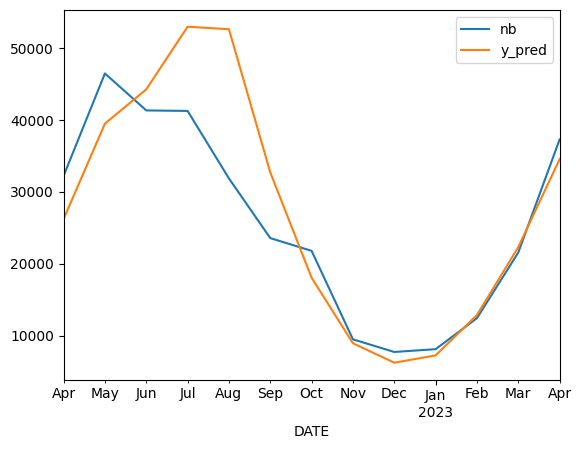

In [ ]:
test.plot()

## 8. Utilisation du modèle pour prédiction des 24 prochains mois

In [ ]:
# Mise à l'échelle du dataset
sc = MinMaxScaler()
df_sc = sc.fit_transform(df)


In [ ]:
# Vérification par l'affichage des données mise à l'échelle
df_sc

array([[0.00000000e+00],
       [8.03073384e-04],
       [1.43467975e-02],
       [5.11579450e-02],
       [6.06428928e-02],
       [7.77027760e-02],
       [8.15228008e-02],
       [6.94767000e-02],
       [2.96268964e-02],
       [5.40012589e-02],
       [1.56924880e-02],
       [8.31289475e-03],
       [2.04024049e-03],
       [3.58127320e-03],
       [1.90133050e-02],
       [6.43760988e-02],
       [9.20495735e-02],
       [1.20981920e-01],
       [1.28470037e-01],
       [9.61517592e-02],
       [6.05126647e-02],
       [3.93288911e-02],
       [1.46723678e-02],
       [1.47374818e-02],
       [1.42382740e-02],
       [1.75373863e-02],
       [6.06428928e-02],
       [1.14948017e-01],
       [1.76958305e-01],
       [2.30199900e-01],
       [2.74737916e-01],
       [2.90343585e-01],
       [1.42643197e-01],
       [1.02489527e-01],
       [3.15152041e-02],
       [3.20795260e-02],
       [2.96486011e-02],
       [6.61124737e-02],
       [1.16771211e-01],
       [2.65383196e-01],


In [ ]:
# Période de prévisions
interval = 24
# On définit la longueur de la séquence d'entrée, ici le modèle utilise 12 valeur pour prédire la prochaine
sequence_length = 12
#initialisation d'une liste pour stocker les prévisions
forecast = []
# Sélection des dernière ligne du dataframe
sc_df_lastrows = df_sc[-sequence_length:]
#Préparation de ces dernière ligne en vue d'une utilisation comme séquence d'entréé pour les prévisions
batch1 = sc_df_lastrows.reshape((1, sequence_length, 1))

In [ ]:
sc_df_lastrows

array([[1.        ],
       [0.88830769],
       [0.88676665],
       [0.68291624],
       [0.5025286 ],
       [0.46400278],
       [0.19664446],
       [0.15848762],
       [0.16688733],
       [0.26067328],
       [0.45881536],
       [0.80055564]])

In [ ]:
batch1

array([[[1.        ],
        [0.88830769],
        [0.88676665],
        [0.68291624],
        [0.5025286 ],
        [0.46400278],
        [0.19664446],
        [0.15848762],
        [0.16688733],
        [0.26067328],
        [0.45881536],
        [0.80055564]]])

In [ ]:
for _ in range(interval):
  # Utilisation du modèle pour faire des prédictions
  pred1 = model.predict(batch1)
  # On ajoute les prévisions à la liste forcasts
  forecast.append(pred1[0])
  # Mise à jour de la prochaine séquence d'entrée pour les prochaines itérations
  batch1 = np.append(batch1[:,1:,:],[pred1],axis=1)

1/1 [==============================] - 0s 30ms/step


In [ ]:
forecast

[array([1.2331362], dtype=float32),
 array([1.2765489], dtype=float32),
 array([1.2997642], dtype=float32),
 array([1.0870672], dtype=float32),
 array([0.74603647], dtype=float32),
 array([0.49153233], dtype=float32),
 array([0.21595134], dtype=float32),
 array([0.16123731], dtype=float32),
 array([0.19953209], dtype=float32),
 array([0.3515695], dtype=float32),
 array([0.61259437], dtype=float32),
 array([1.01443], dtype=float32),
 array([1.5516474], dtype=float32),
 array([1.776885], dtype=float32),
 array([1.8511586], dtype=float32),
 array([1.6210895], dtype=float32),
 array([1.0530119], dtype=float32),
 array([0.51124334], dtype=float32),
 array([0.1894852], dtype=float32),
 array([0.11496517], dtype=float32),
 array([0.1906036], dtype=float32),
 array([0.42732456], dtype=float32),
 array([0.8100724], dtype=float32),
 array([1.3348484], dtype=float32)]

In [ ]:
#Inversion de la transformation de mise à l'échelle
forecast = sc.inverse_transform(forecast)
#Visualtion des forecast
forecast

array([[57223.28308582],
       [59223.43573999],
       [60293.03397512],
       [50493.4492451 ],
       [34781.13827938],
       [23055.36884403],
       [10358.52601458],
       [ 7837.68678375],
       [ 9602.0420571 ],
       [16606.86173686],
       [28633.06022811],
       [47146.83551311],
       [71898.05179811],
       [82275.42410946],
       [85697.43104982],
       [75097.45461988],
       [48924.41700268],
       [23963.51455832],
       [ 9139.15195133],
       [ 5705.79030606],
       [ 9190.67961453],
       [20097.1246033 ],
       [37731.46670008],
       [61909.4705143 ]])

In [ ]:
# Création d'un nouveau dataframe avec les dates futures
fc_index = pd.date_range(start='2023-05-01', periods=interval, freq='MS')
fc_df = pd.DataFrame(forecast, index=fc_index, columns=['forecast'])

In [ ]:
#Affichage des données de prévisions
fc_df

,forecast
2023-05-01,57223.283086
2023-06-01,59223.435740
2023-07-01,60293.033975
2023-08-01,50493.449245
2023-09-01,34781.138279
2023-10-01,23055.368844
2023-11-01,10358.526015
2023-12-01,7837.686784
2024-01-01,9602.042057
2024-02-01,16606.861737


<Axes: xlabel='DATE'>

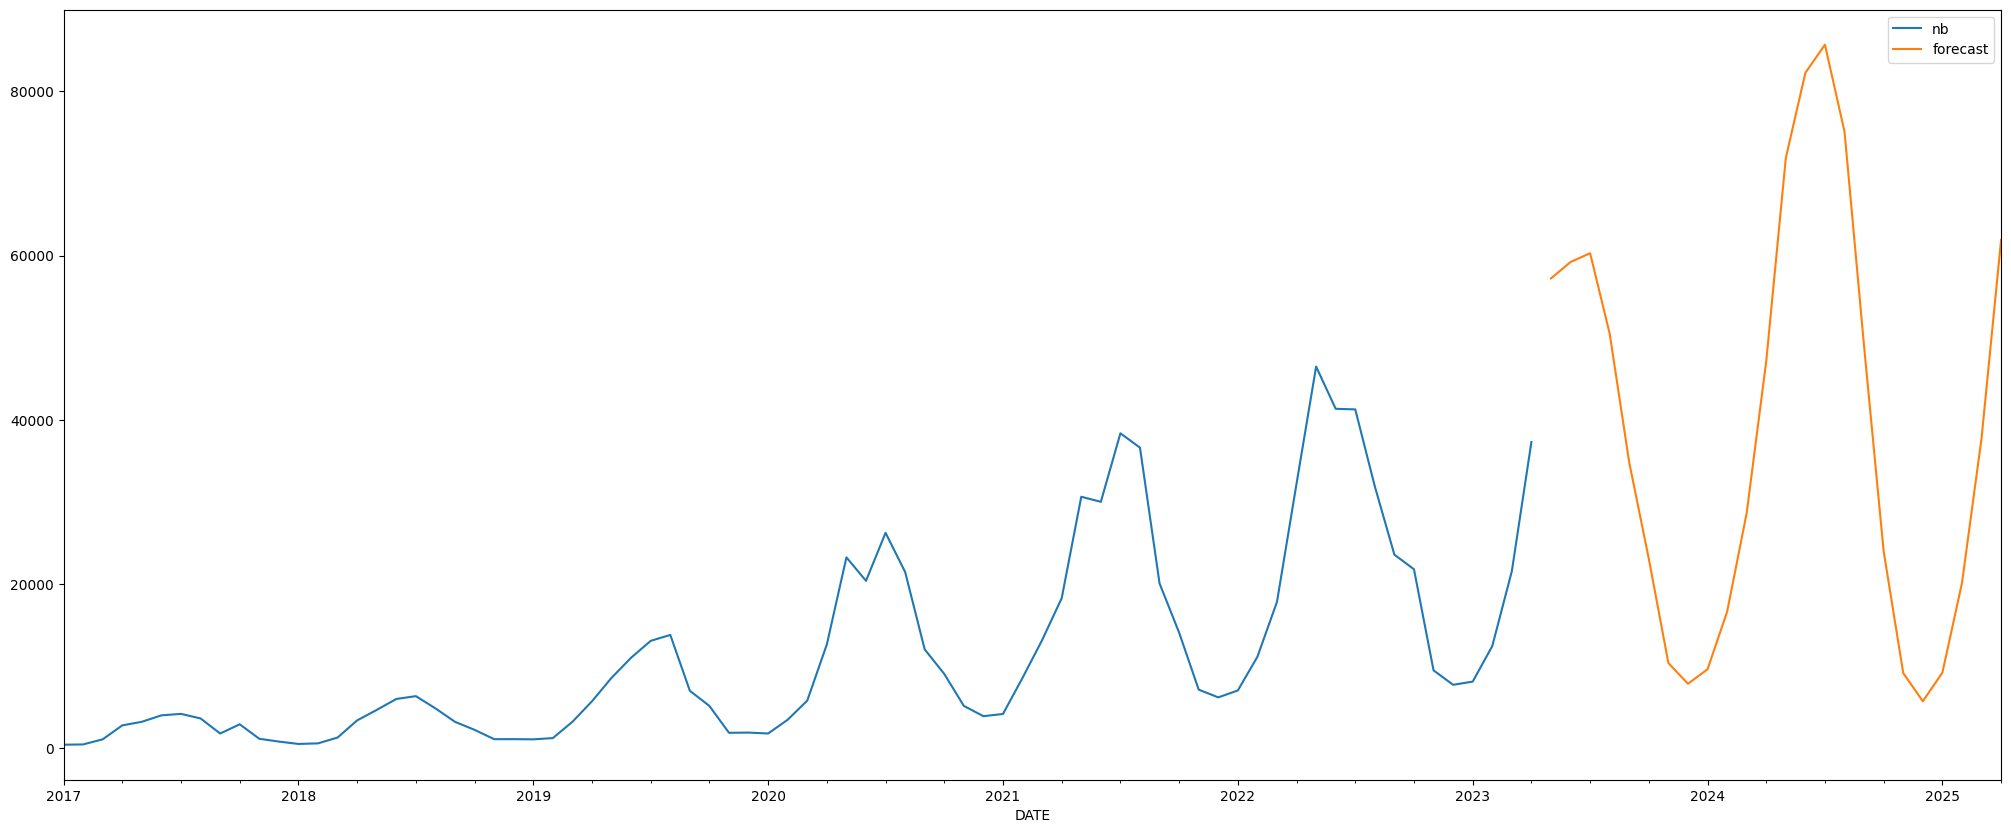

In [ ]:
# Construction d'un graphique avec visualisation des prévisions effectuées par le modèle
ax = df.plot()
fc_df.plot(ax=ax, figsize=(25,10))